In [1]:
# TensorFlow Hub is a way to share pretrained model components.
# 1. How to use TensorFlow Hub with tf.keras.
# 2. How to do image classification using TensorFlow Hub.
# 3. How to do simple transfer learning.

from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

!pip install -q tf-nightly-gpu-2.0-preview
import tensorflow as tf

     |████████████████████████████████| 349.0MB 57kB/s 
     |████████████████████████████████| 61kB 26.7MB/s 
     |████████████████████████████████| 3.1MB 53.1MB/s 
     |████████████████████████████████| 430kB 52.6MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [0]:
!pip install -q tensorflow_hub
import tensorflow_hub as hub

from tensorflow.keras import layers

In [0]:
## An ImageNet classifier
# Download the classifier
# Use hub.module to load a mobilenet, and tf.keras.layers.Lambda to wrap it up as a keras layer. 
classifier_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


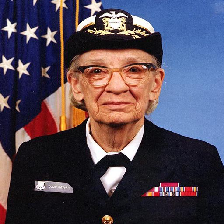

In [5]:
## Run it on a single image
# Download a single image to try the model on.
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
# Add a batch dimension, and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [12]:
# The result is a 1001 element vector of logits,
# rating the probability of each class for the image.
# So the top class ID can be found with argmax
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [13]:
## Decode the predictions
# We have the predicted class ID, Fetch the ImageNet labels, and decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


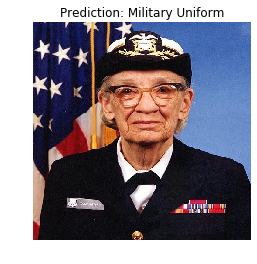

In [14]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [15]:
## Simple transfer leraning
# Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.
# For this example will use TF flowers dataset
data_root = tf.keras.utils.get_file(
    'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

228818944/228813984 [==============================] - 3s 0us/step


In [19]:
# The simplest way to load this data into our model is using 
# tf.keras.preprocessing.image.ImageDataGenerator
# All of TensorFlow Hub's image modules expect float inputs in the [0, 1] range. 
# Use the ImageDataGenerator's rescale parameter to achieve this.
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [20]:
for image_batch, label_batch in image_data:
    print('Image batch shape: ', image_batch.shape)
    print('Label batch shape: ', label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [21]:
## Run the classifier on a batch of images
# Now run the classifer on the image batch
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [22]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['nail', 'bee', 'coral fungus', 'ladybug', 'daisy', 'coral fungus',
       'hip', 'daisy', 'pot', 'daisy', 'alp', 'pot', 'vase',
       'picket fence', 'cabbage butterfly', 'daisy', 'cardoon',
       'picket fence', 'coral fungus', 'quill', 'daisy', 'cardoon',
       'bottlecap', 'bee', 'mushroom', 'ant', 'picket fence', 'daisy',
       'daisy', 'picket fence', 'bee', 'daisy'], dtype='<U30')

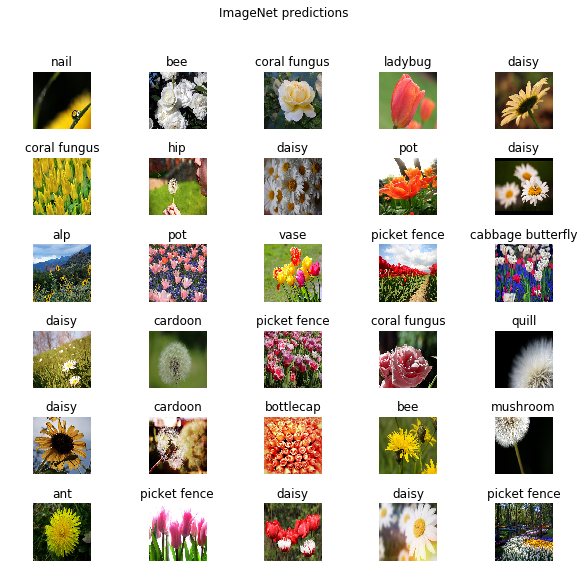

In [25]:
# Check how these predictions line up with the images
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle('ImageNet predictions')

In [0]:
# The results are far from perfect, but reasonable considering that these are not the classes the model was trained for (except "daisy").

In [0]:
## Download the headless model
# TensorFlow Hub also distributes models without the top classification layer
# These can be used to easily do transfer learning.
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

In [0]:
# Create the feature extractor
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [44]:
# It returns a 1280-length vector for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
# Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.
feature_extractor_layer.trainable = False

In [46]:
## Attach a classification head
# Now wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [48]:
predictions.shape

TensorShape([32, 5])

In [0]:
## Train the model
# Use compile to configure the training process
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

In [0]:
# Now use the .fit method to train the model.
# To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
     
    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [56]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback = CollectBatchStats()

history = model.fit(image_data,
                    epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/20


W0523 18:55:57.202228 140380166076288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 20s 171ms/step - loss: 0.8668 - acc: 0.8438
Epoch 2/20
115/115 [==============================] - 16s 140ms/step - loss: 0.5306 - acc: 0.8438
Epoch 3/20
115/115 [==============================] - 17s 146ms/step - loss: 0.4375 - acc: 0.8125
Epoch 4/20
115/115 [==============================] - 16s 141ms/step - loss: 0.4245 - acc: 0.9688
Epoch 5/20
115/115 [==============================] - 17s 148ms/step - loss: 0.3899 - acc: 0.8750
Epoch 6/20
115/115 [==============================] - 17s 145ms/step - loss: 0.3639 - acc: 0.8750
Epoch 7/20
115/115 [==============================] - 16s 141ms/step - loss: 0.3576 - acc: 0.9062
Epoch 8/20
115/115 [==============================] - 16s 141ms/step - loss: 0.3384 - acc: 0.9062
Epoch 9/20
115/115 [==============================] - 16s 141ms/step - loss: 0.3099 - acc: 0.9375
Epoch 10/20
115/115 [==============================] - 17s 150ms/step - loss: 0.3286 - acc: 0.9062
Epoch 11/20
115/115 [=========

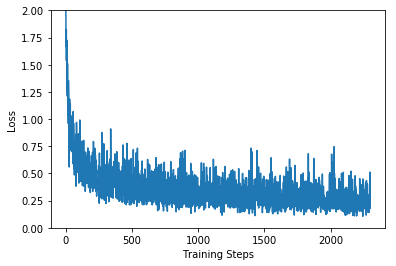

In [58]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)

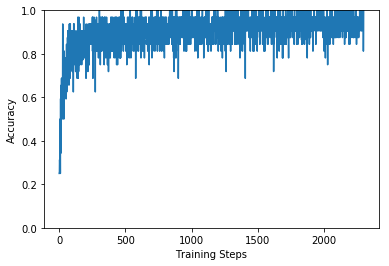

In [59]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)

In [63]:
## Check the predictions
# To redo the plot from before, first get the ordered list of class names:
class_names = sorted(image_data.class_indices.items(), key=lambda pair: pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
# Run the image batch through the model and comvert the indices to class names.
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
# True label
label_id = np.argmax(label_batch, axis=-1)

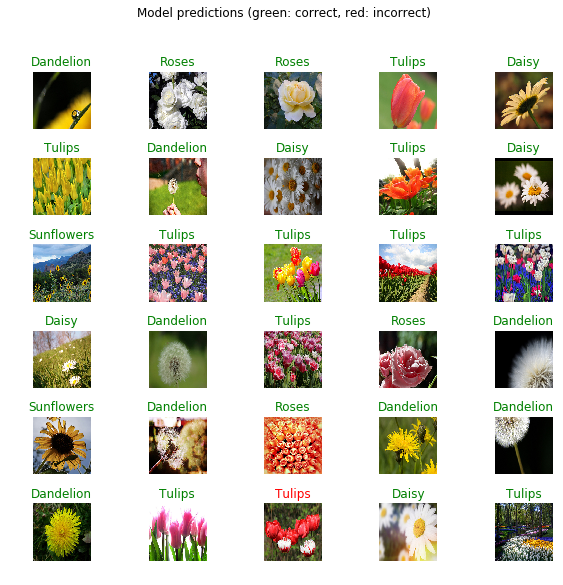

In [68]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')

In [70]:
## Export model
import time
t = time.time()

export_path = '/tmp/saved_models/{}'.format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0523 19:14:10.511142 140380166076288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0523 19:14:10.512748 140380166076288 export_utils.py:182] Export includes no default signature!
W0523 19:14:11.133684 140380166076288 meta_graph.py:448] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0523 19:14:17.165616 140380166076288 export_utils.py:182] Export includes no default signature!
W0523 19:14:17.781839 140380166076288 m

'/tmp/saved_models/1558638843'

In [72]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects = {'KerasLayer': hub.KerasLayer})

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7faa582def98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7faa581f7e48>,)


In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [74]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [79]:
print(np.mean(np.argmax(result_batch, axis=-1) == label_id))

0.96875
